In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive/DoubleSac

[Errno 2] No such file or directory: 'MyDrive/DoubleSac'
/content/drive/MyDrive/DoubleSac


In [ ]:
cd MisLoc

/content/drive/MyDrive/DoubleSac/MisLoc


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gamma as gammaFn
import pdb
from scipy.signal import find_peaks

class CANN1D: # One dimentional continuous attractor neural network model
    def __init__(self,args):

        self.totX = args.totX  # deg, retinal visual space range
        self.halfX = int(self.totX/2) # deg
        self.Nx = args.Nx # number of units covering totX
        self.dx = self.totX / self.Nx # deg/unit, spatial step size
        self.xs = np.arange(-self.halfX, self.halfX, self.dx) # deg, units' RF centers, fovea at 0 (center)
        self.x0 = args.x0 # deg, position of visual input relative to fixation (fovea) before saccade
        self.e0 = args.e0 # initial eye position (and initial fixation) relative to the screen center

        self.totT = args.totT # ms, total simulation time
        self.halfT = int(args.totT/2)
        self.dt = args.dt # ms, time step, 1
        self.tau = args.tau # ms, time constant
        self.Nt = int(self.totT/self.dt) # number of time steps

        self.sacDur = args.sacDur # ms, saccade duration, 50
        self.halfSacDur = args.sacDur//2

        self.probeOn = args.probeOn
        self.respDelay = args.respDelay # ms, hard-shift part of retina to LIP input delay
        #  saccade onset; saccade duration covers the middle part of simulation T.
        self.sacOn = self.halfT-self.halfSacDur # ms
        self.sacOff = self.halfT+self.halfSacDur # ms


        self.ts = np.arange(0, self.totT, self.dt) # sampled times from 0
        self.tt = self.ts - self.sacOn # sampled times relative to saccade onset

        self.excSigma = args.excSigma # deg
        self.inhSigma = args.inhSigma
        self.excAmp = args.excAmp
        self.inhAmp = args.inhAmp
        self.inputSigma = args.inputSigma
        self.inputAmp = args.inputAmp # input amplitude

        # symmetric connections
        self.Exc = self.excAmp*self._conn_sym(self.excSigma) # excitation part
        self.Inh = self.inhAmp*self._conn_sym(self.inhSigma) # inhibition part
        self.Jsym = self.Exc-self.Inh # net, Mexican-hat connections
        # anti-symmetric connections as 1st spatial derivative of symmetric connections
        self.dExc_dx = self.excAmp*self._conn_asy(self.excSigma)
        self.dInh_dx = self.inhAmp*self._conn_asy(self.inhSigma)
        self.Jasy = self.dExc_dx #- self.dInh_dx # also works if only use the 1st, exc part

        self.u = np.zeros(self.Nx)    # initialize states (membrane potentials)
        self.r = np.zeros(self.Nx)    # initialize activities (firing rates)
        self.input = np.zeros(self.Nx)    # initializw external visual input

        self.cdSigma = args.cdSigma
        self.cdAmp = args.cdAmp # maximum cd strength
        self.cdShift = args.cdShift
        self.cd = self._set_cd(self.cdAmp, self.cdSigma)

        # saccade suppression
        self.cdk = args.cdk # parameter for saccade supression
        self.suppress = self._set_sacsupress(self.cd, self.cdk)

        # use gamma pdf for temporal response
        self.gammaShape = args.gammaShape
        self.gammaScale = args.gammaScale
        self.gammaPeakT = (self.gammaShape - 1)*self.gammaScale # ms
        self.gammaFunc = gammaFn.pdf

        # attention at the target which is sacAmp deg to the right of initial fixation
        self.attSigma = args.attSigma # deg, attention sigma
        self.attAmp = args.attAmp # attention amplitude
        # no attention at target in [noAtt1, noAtt2]. maybe use CD to gate attention ??
        self.noAttInd1 = int((self.sacOn - 100)/self.dt) # ms
        self.noAttInd2 = int((self.sacOff + 100)/self.dt) # ms

    def _conn_sym(self,sigma):
        """
        Symmetric connections as a 1d gaussian (unnormalized, with peak = 1)
        """
        Jxx = np.zeros((self.Nx, self.Nx))
        for i in range(self.Nx):
            for j in range(self.Nx):
                Jxx[i][j] = \
                np.exp(-0.5 * np.square((self.xs[i] - self.xs[j]) / sigma))
        return Jxx

    def _conn_asy(self,sigma):
        """
        Asymmetric connection as first-order derivative of a 1d gaussian function (unnormalized)
        """
        Jax = np.zeros((self.Nx, self.Nx))
        Jxx = self._conn_sym(sigma)
        for i in range(self.Nx):
            for j in range(self.Nx):
                Jax[i][j] = -Jxx[i][j]*(self.xs[j]-self.xs[i])/(sigma**2) # only true if Jsym is a gaussian
        return Jax

    def _set_cd(self, cdAmp, cdSigma):
        '''
        set cd signal as a 1d gaussian (unnormalized); time 0 should be mid saccade ??
        '''

        z = np.exp(-0.5*((self.ts - self.halfT-self.cdShift)/cdSigma)**2)

        return z*cdAmp

    def _set_sacsupress(self, cd, cdk):
        #cd = self._set_cd()
        self.suppress = 1./(1+cdk*np.abs(cd)) #saccade suppression function: 1/(1+k*cd) # suppress=1 means no suppression
        return self.suppress



    def set_gaussianInput(self, Amp, x0):

        gs = [self._gaussianBump(Amp, x0)] # the [] is need to for repeat to stack them
        self.input = np.repeat(gs, self.Nt, axis=0)


        return self.input

    def _gaussianBump(self, Amp, x0):
        '''
        gaussian centered at x0 with amplitude Amp
        '''
        gs = Amp * np.exp(-0.5 * np.square((self.xs - x0) / self.inputSigma));
        return gs

    def set_gammaInput(self, loc, shape, scale):
        """
        Gamma pdf function  does cdf case too
        """
        amp = self.gammaFunc(self.ts, shape, loc, scale) # loc is the added delay
        if np.max(amp) != 0:
            amp = amp/np.max(amp)
        else:
            print('set_gammaInput: max(amp) is 0')
        self.gamma = amp
        return self.gamma

    def setAtt(self, locus, Amp, sigma): # attention modulation factor
        att = 1 + Amp * np.exp(-0.5 * np.square((self.xs - locus) / sigma));
        return att

    def relu_r_or_u(self, u):
        # activation function
        r = 0.5 * (u + np.abs(u))
        return r

    def cann_step(self, i):
        '''
        Run the network for one time step, i is the index of time step
        '''
        self.Jxx  = self.Jsym -self.cd[i]*self.Jasy #  time-varying cd signal modulate the asymmtric part   the products below
        self.u = self.u+(-self.u+np.dot(self.Jxx, self.r)+self.input[i]*self.gamma[i]*self.suppress[i])*self.dt/self.tau
        self.r = self.relu_r_or_u(self.u)
        if self.attAmp != 0:
            if i < self.noAttInd1:
                self.r = self.r * self.att1
            elif i > self.noAttInd2:
                self.r = self.r * self.att2

    def pos_max(self):
        # find  max position of bump activity
        max_index = np.argmax(self.r)
        max_x = self.xs[max_index]
        return max_x

    def centerOfMass(self, x, r):
        x_r = r * x
        tmp = r.sum()
        if tmp != 0:
            center = x_r.sum()/tmp
        else:
            center = np.nan
            print('centerOfMass: denominator is 0.')
        return center



    def runCann(self, probeOn):
        # run model with a probe at probeOn (ms relative to the start of simulation)

        # inputs to recurrent LIP/FEF units
        self.set_gaussianInput(cann.inputAmp, cann.x1) # Set the visual input's spatial position
        self.set_gammaInput(probeOn+cann.respDelay, cann.gammaShape, cann.gammaScale) # set the time course of visual input
        # sptial attention profile
        if self.attAmp != 0:
            self.att1 = self.setAtt(sacAmp, self.attAmp, self.attSigma) # before saccade
            self.att2 = self.setAtt(0, self.attAmp, self.attSigma) # after saccade

        self.snapshots = np.zeros([cann.Nt, cann.Nx]) # initial a list to collect the outputs   Does not use the value of cann.u only its shape
        # run the model step by step and concate the output together at each step

        startTind = int((probeOn + cann.respDelay)/self.dt)
        for i in range(startTind, cann.Nt):
            self.cann_step(i)
            self.snapshots[i] = cann.r

        # determine the start and end Pos of center-of-mass of population activity
        #gammaPeakInd = np.argmax(cann.gamma) # peak time index for gamma input  # this is OK for transient input
        #self.gammaPeakInd = int((probeOn + self.respDelay + self.gammaPeakT)/cann.dt)
        #self.startPos = self.centerOfMass(self.xs, self.snapshots[self.gammaPeakInd])
        self.endPos = self.centerOfMass(self.xs, self.snapshots[-1])


In [2]:
import easydict
# parameters of the model
args = easydict.EasyDict({
    "totX": 180, # deg, visual range (-90,90) deg
    "Nx": 360, # number of recurrent LIP units
    "totT" : 680, # ms, total simulation time
    "dt": 1, # ms, time step
    "tau": 20, # ms, time constant
    "sacDur" : 50, # ms, saccade duration
    "excSigma" : 6, # deg, sigma of the excitation connections
    "inhSigma" : 9.6, # deg, sigma of the inhibition connections
    "excAmp" : 0.165, # amplitude of the excitation connections
    "inhAmp" : 0.1, # amplitude of the inhibition connections
    "inputSigma": 4, # deg, sigma of visual input
    "inputAmp" : 4, # amplitude of the visual input
    "x0" : 6, # deg, position of visual input relative to fixation (fovea) before saccade
    "e0" : -6, # initial eye position (and initial fixation) relative to the screen center
    "cdSigma": 60, # ms, sigma of cd signal
    "cdAmp" : 0.97, # max cd strength
    "respDelay":0, # ms, hard-shift part of retina to LIP delay
    "cdk" : 0, # paramter of saccade suppression
    "cdShift":0,
    "gammaShape": 6, # gamma distribution shape
    "gammaScale": 8, # ms, gamma distribution scale
    "attSigma": 8, # deg, attention sigma
    "attAmp": 0, # 0.1, attention amplitude
    "probeOn":20
})



In [3]:
# run model with a probe well before saccade onset to determine update amplitude
# and set saccade amplutude to the negative of this value. run this block once
# and then run the next block with any probe onset time.

cann = CANN1D(args) # create an instance of CANN1d
cann.attAmp = 0 # no attention

# probe onset on retina
probeOn = 0 # ms, retinal probe on the first time step
probeOnInd = int(probeOn/cann.dt)
cann.x1 = cann.x0 # x1 = x0 for flash before saccade

# probe should be early enough not to miss CD time course
if cann.sacOn - probeOn < cann.cdSigma*3:
    print('probe onset not early enough')

cann.runCann(probeOn)

# set saccade amplitude to the negative of total updating so that the flash
# well before saccade is updated correctly after the saccade. This also means that
# persistent stimuli will be updated correctly, the definition of TSVS.
endPos = cann.centerOfMass(cann.xs, cann.snapshots[-1])
sacAmp = cann.x0 - cann.endPos
print(sacAmp)

midTind = int(cann.Nt/2) # mid index of sampled time array
idealUpdate = sacAmp/(1+np.exp(0.12*(cann.tt - cann.tt[midTind]))) + endPos
eyeTrace = sacAmp/(1+np.exp(-0.12*(cann.tt - cann.tt[midTind]))) + cann.e0

11.95924465269128


In [ ]:
# probeOn = cann.totT-cann.dt
# probeOnInd = int(probeOn/cann.dt)
# print(cann.x0)
# eyeChange = (eyeTrace[probeOnInd] - eyeTrace[0])
# cann.x1 = cann.x0 - eyeChange
# print(cann.x1)

In [4]:
# run the model at any probeOn time
#probeIni = 20
cann = CANN1D(args) # create an instance of CANN1d
# probe onset on retina
probeOn = cann.sacOn# ms cann.probeOn cann.sacOn cann.sacOff probeIni = 20
probeOnInd = int(probeOn/cann.dt)
eyeChange = eyeTrace[probeOnInd] - eyeTrace[0]
# for flashes on a fixed screen position, its retinotopic position changes with eye position
cann.x1 = cann.x0 - eyeChange

cann.runCann(probeOn)

centerOfMass: denominator is 0.


"\nplt.figure(figsize=figSzS)\n\n# a list of time indices for showing population actitivies\n# time of first input to LIP\nfirstInputT = probeOn+cann.respDelay+cann.tau\nplotTs = [firstInputT, cann.totT-cann.dt]\nif firstInputT < cann.sacOn:\n    plotTs = np.insert([cann.sacOn, cann.sacOff], 1, plotTs)\n\nplotTimeInd = np.array(plotTs)/cann.dt\nplotTimeInd = plotTimeInd.astype(int)\n\nfor pInd in plotTimeInd:\n    plt.plot(cann.xs, cann.snapshots[pInd,:]) # plot some snapshots of the bump activity\nplt.xticks([-90,-45,0,45,90],['-90','-45','0','45','90'])\nplt.xlabel('Retinotopic position (deg)',fontsize = fontsize)\n"

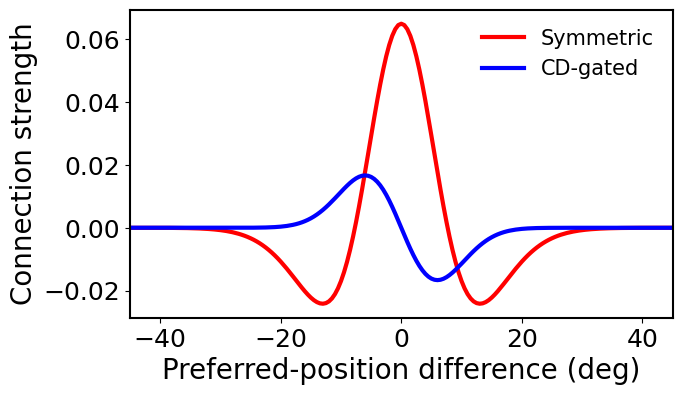

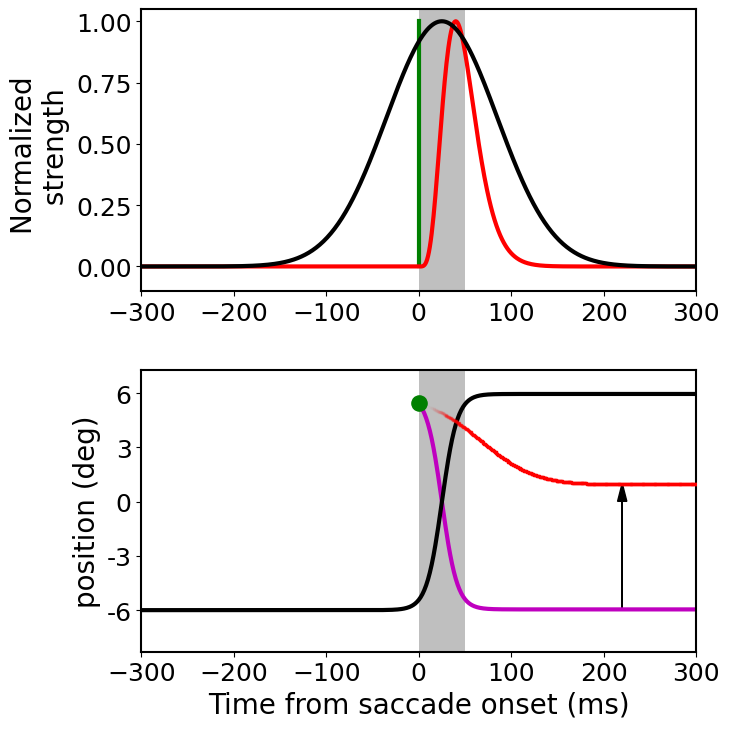

In [5]:
# plot the results for one probeOn time
from matplotlib import colormaps
import matplotlib
#plt.rcParams['figure.figsize'] = (7, 4)
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize']= 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['lines.linewidth'] = 3

figSzS = (7, 4)
figSzB = (8, 8)
lgndSz = 15
fontsize = 20
# spatial recurrent connections
plt.figure(figsize=figSzS)

midIx = int(cann.Nx/2)
plt.plot(cann.xs, cann.Jsym[midIx], 'r', label='Symmetric')
plt.plot(cann.xs, cann.Jasy[midIx], 'b', label='CD-gated')
#plt.legend(loc='upper right',fontsize = 15)
#if probeOn == probeIni:

lgnd = plt.legend(loc=0, prop={'size': lgndSz})
lgnd.get_frame().set_linewidth(0.0)
lgnd.get_frame().set_facecolor('none')
plt.xlabel('Preferred-position difference (deg)',fontsize = fontsize)
plt.ylabel('Connection strength',fontsize = fontsize)
plt.xlim([-45,45])


# time courses
plt.figure(figsize=figSzB)

ax = plt.subplot(211)
# flash time
ax.plot([probeOn-cann.sacOn,probeOn-cann.sacOn],[0,1],'g',label='Flash onset')
# time course of the LIP/FEF input (gamma function)
gInput = cann.gamma/np.max(cann.gamma)
ax.plot(cann.tt, gInput, 'r', label='LIP/FEF input')
# cd time course
cd = cann.cd/np.max(cann.cd) # normalize
ax.plot(cann.tt, cd,'k',label='CD')
#plt.legend(loc='upper right')
if probeOn == cann.probeOn:

 lgnd = ax.legend(loc=(0.635,0.62), prop={'size': lgndSz},fontsize =15)
 lgnd.get_frame().set_linewidth(0.0)
 lgnd.get_frame().set_facecolor('none')
#plt.legend(loc=(0.65,0.62))
ax.fill_between([0,cann.sacDur], -0.1, 1.1, facecolor='grey', alpha = 0.5)
plt.ylabel('Normalized \n strength',fontsize = fontsize)
#plt.xlim([-cann.halfT, cann.halfT])
plt.xlim([-300, 300])
plt.ylim([-0.1, 1.05])


ax = plt.subplot(212)

# time index for having cortical (LIP/FEF) responses
ctxOnInd = int((probeOn+cann.respDelay)/cann.dt) # add cann.dt for the response to appear

#ax.scatter(cann.tt[probeOnInd], cann.x1, s=120,color='r',label='Flash onset',marker='o',zorder=11)
ax.scatter(cann.tt[probeOnInd], cann.x1, s=120, color='g', label='Flash onset', marker='o',zorder=10)# input marker

com_list = [] # center of mass
max_fr = []
for i in range(ctxOnInd, cann.Nt):
    #peaks, _ = find_peaks(snapshots[i,:], height=0) # get the peak position of the bump.
    center = cann.centerOfMass(cann.xs, cann.snapshots[i,:])
    com_list.append(center)
    max_fr.append(cann.snapshots[i,:].max())
norm_fr = np.array(max_fr)/np.array(max_fr).max()
#norm_alpha = norm_fr
plt_t = cann.tt[ctxOnInd:cann.Nt]
plt_y = com_list
if True:
 for ip in range(len(com_list)):
    if ip == 0:
      line = plt.plot(plt_t[ip],plt_y[ip],color='r',label='Actual updating')
    line = plt.scatter(plt_t[ip],plt_y[ip],4,color='r',alpha=norm_fr[ip] ,marker='s',zorder=11) # norm_fr[ip]
    line = plt.gca().lines[-1]
    line.set_zorder(10)


plt.plot(cann.tt[ctxOnInd:cann.Nt], idealUpdate[ctxOnInd:cann.Nt], label='Ideal updating',color='m') # ideal updating
plt.plot(cann.tt, eyeTrace, label='Eye trace',color='k')
if probeOn == cann.probeOn:#
 lgnd = ax.legend(loc=0, prop={'size': lgndSz})
 lgnd.get_frame().set_linewidth(0.0)
 lgnd.get_frame().set_facecolor('none')
plt.yticks([-6,-3,0,3,6],['-6','-3','0','3','6'])
plt.xlabel('Time from saccade onset (ms)',fontsize = fontsize)
plt.ylabel('position (deg)',fontsize = fontsize)
ax.fill_between([0,cann.sacDur], -10, 10, facecolor='grey', alpha = 0.5)
if probeOn == cann.sacOn:
  plt.arrow(220,-sacAmp/2,0,6,head_width=10,head_length=1,color='k')
if probeOn == cann.sacOff:
  plt.arrow(220,-sacAmp/2,0,-0.52,head_width=7,head_length=0.5,color='k')
#plt.xlim([-cann.halfT, cann.halfT])
plt.xlim([-300,300])
plt.ylim([-8.3,7.3])
plt.tight_layout()  # Adjusts layout to prevent overlap






In [ ]:
probeOn

315

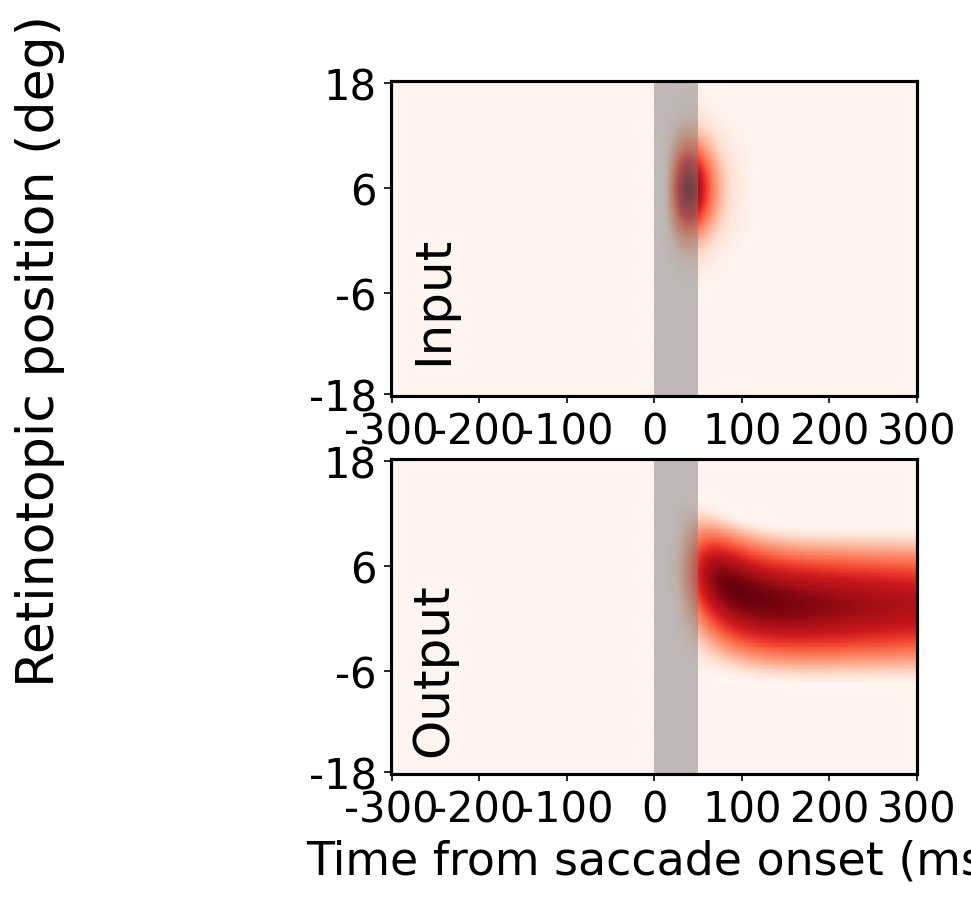

In [10]:
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.labelsize']= 25
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['lines.linewidth'] = 3


fig=plt.figure(figsize=(8,6),dpi = 150)
aspect = 5
fontsize=22
plotInd=[180-36,180+36]
plotY = [15,615]
sacOn = cann.sacOn-plotY[0]
sacOff = cann.sacOff-plotY[0]
Nx = plotInd[1]-plotInd[0]
ax = plt.subplot(211)
plt.subplots_adjust( wspace=-0.1)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.0, hspace=0.0)

#cann.input.shape
gauss_input = cann.input

gamma = cann.gamma[:,np.newaxis]
tem_input = np.repeat(gamma, args.Nx, axis=1)
input_all = tem_input*gauss_input
input_all = input_all.T
input_all = np.flipud(input_all)
#input_all.shape
cmap = plt.cm.Reds
max_value = input_all.max()
min_value = input_all.min()
#ax.fill_between([-1,Nx],sacOn,sacOff,facecolor='grey', alpha = 0.5)
ax.fill_between([sacOn,sacOff],-1,Nx,facecolor='grey', alpha = 0.5)
plt.imshow(input_all[plotInd[0]:plotInd[1],plotY[0]:plotY[1]],cmap=cmap, vmin=min_value, vmax=max_value)
ax.text(20,62,'Input',rotation=90,fontsize=24)
ax.set_aspect(aspect)

plt.yticks([0,24,48,71],['18','6','-6','-18'])
plt.xticks([sacOn-300,sacOn-200,sacOn-100,sacOn,sacOn+100,sacOn+200,sacOn+300],['-300','-200','-100','0','100','200','300'])


fig.text(-0.02,0.22,'Retinotopic position (deg)',fontsize = 25,rotation=90)


ax = plt.subplot(212)

cmap = plt.cm.Reds
max_value = cann.snapshots.max()
min_value = cann.snapshots.min()
snapshots = cann.snapshots.T
snapshots = np.flipud(snapshots)
#ax.fill_between([-1,Nx],sacOn,sacOff,facecolor='grey', alpha = 0.5,zorder=1)
ax.fill_between([sacOn,sacOff],-1,Nx,facecolor='grey', alpha = 0.5)
plt.imshow(snapshots[plotInd[0]:plotInd[1],plotY[0]:plotY[1]],cmap=cmap, vmin=min_value, vmax=max_value)
ax.set_aspect(aspect)
ax.text(20,65,'Output',rotation=90,fontsize=24)

plt.yticks([],[])


plt.yticks([0,24,48,71],['18','6','-6','-18'])
plt.xticks([sacOn-300,sacOn-200,sacOn-100,sacOn,sacOn+100,sacOn+200,sacOn+300],['-300','-200','-100','0','100','200','300'])
plt.xlabel('Time from saccade onset (ms)',fontsize = fontsize)

plt.subplots_adjust( wspace=0.0)


In [ ]:
cann.x1

6.0

In [ ]:
args.cdShift

20

In [ ]:
# run the mislocalization curve
# a list of flash times for the mislocalization curve
cann.respDelay=20
probeOnList = np.array([0, cann.totT-cann.respDelay-2*cann.dt]) # 2dt for responses to appear
probeOnList = np.insert(probeOnList, 1, np.arange(cann.halfT-180,cann.halfT+120,10)) # insert a list of times
probeOnList = np.arange(0,cann.totT-30,5) # time points of the curve
max_x = [] # initiaize a list to collect the center-of-mass position of population activity
flash_pos = []
# Fig4a args.cdShift = 0,args.respDelay=0;
# Fig4b args.cdShift = 0,args.respDelay=20;
# Fig4c args.cdShift = 20,args.respDelay=0.
args.cdShift = 0
args.respDelay=20
for _probeOnset in probeOnList: # run the model for each time points
      cann = CANN1D(args)


      probeOnInd = int(_probeOnset/cann.dt)
      eyeChange = (eyeTrace[probeOnInd] - eyeTrace[0])
      cann.x1 = cann.x0 - eyeChange # flash retinal position
      flash_pos.append(cann.x1)

      cann.runCann(_probeOnset)

      max_x_ = cann.centerOfMass(cann.xs, cann.r)
      #max_x_ = cann.intp_pos_max() # interpolation
      max_x.append(max_x_)



In [ ]:
probeOnList

array([  0, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400,
       410, 420, 430, 440, 450, 678])

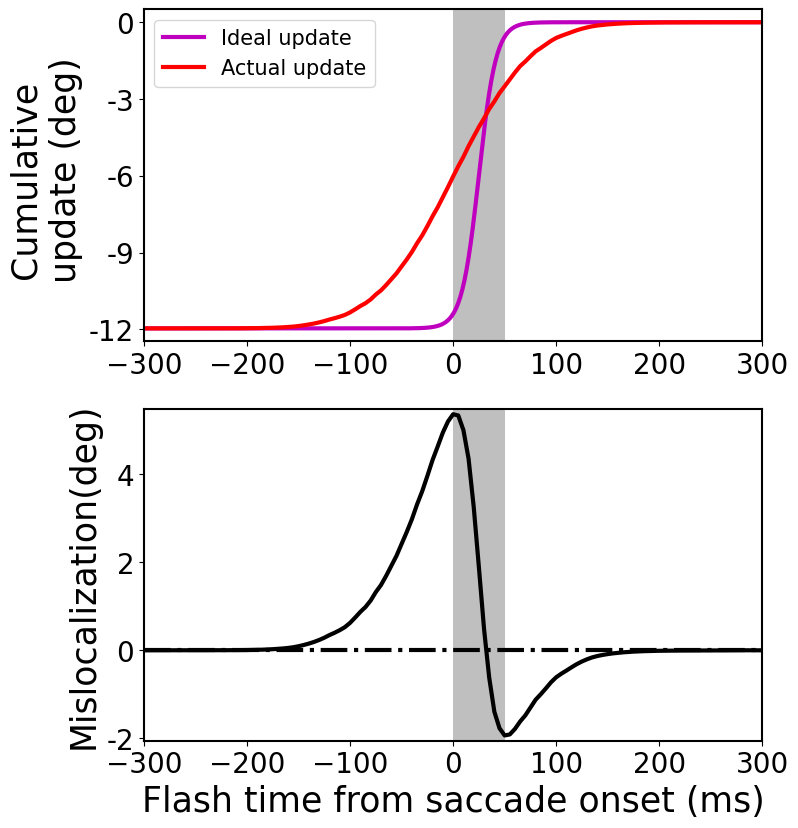

In [ ]:
# plot the mislocalization curve

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize']= 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

plt.figure(figsize=(8,8))

ax = plt.subplot(211)
idealTotalUpdate = idealUpdate[-1] - idealUpdate

ax.plot(cann.tt, idealTotalUpdate, label='Ideal update', color='m')
totalUpdate = np.array(max_x) - np.array(flash_pos)
ax.plot(probeOnList-cann.sacOn, totalUpdate, label='Actual update', color='r')
plt.legend(loc=0, prop={'size': lgndSz})
plt.xlim([-cann.halfT, cann.halfT])

plt.ylim([-12.1, 0.1])
plt.xlim([-300,300])
plt.tight_layout()  # Adjusts layout to prevent overlap

plt.ylabel('Cumulative \n update (deg)')
ax.fill_between([0, cann.sacDur], -sacAmp-0.5, 0.5, facecolor='grey',alpha = 0.5)
plt.yticks([-12,-9,-6,-3,0],['-12','-9','-6','-3','0'])
plt.ylim([-sacAmp-0.5,0.5])
plt.subplot(212)

# translational mislocalization
probeOnInd = probeOnList/cann.dt
probeOnInd = probeOnInd.astype(int)
transMisloc = totalUpdate - idealTotalUpdate[probeOnInd] # (actual-ideal)
plt.plot(cann.tt[probeOnInd], transMisloc,'k')
plt.xlabel('Flash time from saccade onset (ms)')
#plt.xlim([-cann.halfT, cann.halfT])

mislocMin = np.min(transMisloc)
mislocMax = np.max(transMisloc)
plt.fill_between([0, cann.sacDur], mislocMin-0.12, mislocMax+0.12, facecolor='grey',alpha = 0.5)
plt.yticks([-2,0,2,4,6,8],['-2','0','2','4','6','8'])
plt.ylim([mislocMin-0.12, mislocMax+0.12])
plt.xlim([-300,300])

#plt.ylim([np.min(shift_trans)-0.5,np.max(shift_trans)+1])
#plt.ylabel('Mislocalization(deg)',labelpad = 21)
plt.ylabel('Mislocalization(deg)')

plt.plot([-300,args.totT//2],[0,0],linestyle='dashdot',c='k')




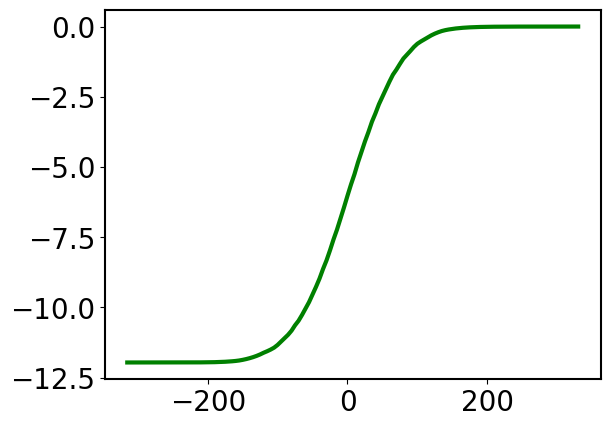

In [ ]:
plt.plot(probeOnList-cann.sacOn, totalUpdate, label='actual update', color='g')
with open('cd2.npy', 'wb') as f:
    np.save(f, totalUpdate)
    np.save(f,probeOnList)


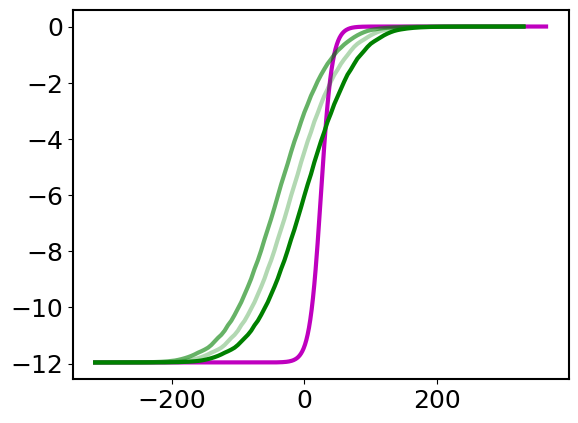

In [ ]:
idealTotalUpdate = idealUpdate[-1] - idealUpdate
probeOnList = np.array([0, cann.totT-cann.respDelay-2*cann.dt]) # 2dt for responses to appear
probeOnList = np.insert(probeOnList, 1, np.arange(cann.halfT-180,cann.halfT+120,10)) # insert a list of times
probeOnList = np.arange(0,cann.totT-30,5) # time points of the curve
with open('cd0.npy', 'rb') as f:
    cd0 =  np.load(f)
    #pro = np.load(f)
with open('cd1.npy', 'rb') as f:
    cd1 =  np.load(f)
    #pro = np.load(f)
with open('cd2.npy', 'rb') as f:
    cd2 =  np.load(f)
    #pro = np.load(f)
plt.plot(cann.tt,idealTotalUpdate,'m',zorder=0)
plt.plot(probeOnList-cann.sacOn,cd0,'g',alpha = 0.3)
plt.plot(probeOnList-cann.sacOn,cd1,'g',alpha = 0.6)
plt.plot(probeOnList-cann.sacOn,cd2,'g',alpha = 1)



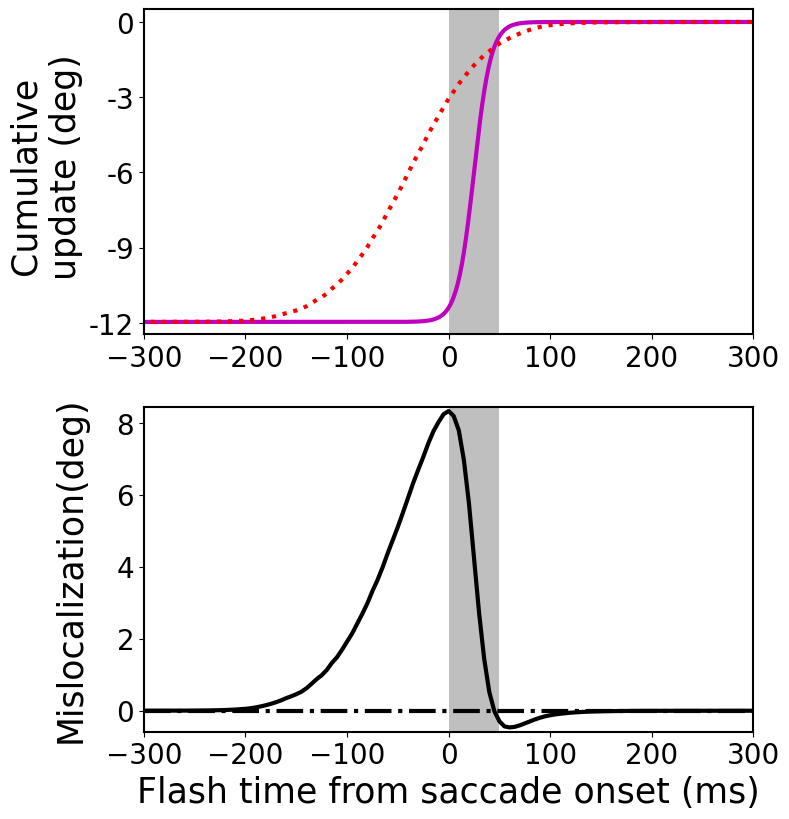

In [ ]:
# plot the mislocalization curve and inset in fig4c
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
probeOn = 100
#args.cdShift = 20
probeOnList = np.arange(0,cann.totT-30,5) # time points of the curve
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 23
plt.rcParams['axes.labelsize']= 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

fig = plt.figure(figsize=(8,8))

ax = plt.subplot(211)
idealTotalUpdate = idealUpdate[-1] - idealUpdate

ax.plot(cann.tt, idealTotalUpdate, label='Ideal update', color='m')
totalUpdate = np.array(max_x) - np.array(flash_pos)
ax.plot(probeOnList-cann.sacOn, totalUpdate, label='Actual update', color='r',linestyle=':') #linestyle=':'linestyle='dashed'
if probeOn ==20:
 plt.legend(loc=0, prop={'size': lgndSz})
plt.xlim([-cann.halfT, cann.halfT])

plt.ylim([-12.1, 0.1])
plt.xlim([-300,300])
plt.tight_layout()  # Adjusts layout to prevent overlap

plt.ylabel('Cumulative \n update (deg)')
ax.fill_between([0, cann.sacDur], -sacAmp-0.5, 0.5, facecolor='grey',alpha = 0.5)
plt.yticks([-12,-9,-6,-3,0],['-12','-9','-6','-3','0'])
plt.ylim([-sacAmp-0.5,0.5])


# inset

#inset_ax = inset_axes(ax, width="30%", height=1.2, bbox_to_anchor=(0.5,0,1,1))
if args.cdShift == 20:
  inset_ax = fig.add_axes([0.25, .7, .2, .2])  # [x, y, width, height] w.r.t. fig
  plt.plot(cann.tt,idealTotalUpdate,'m',zorder=0)
  plt.plot(probeOnList-cann.sacOn,cd0,'r',alpha = 1)
  plt.plot(probeOnList-cann.sacOn,cd1,'r',alpha = 1,linestyle=':')
  plt.plot(probeOnList-cann.sacOn,cd2,'r',alpha = 1,linestyle='dashed')
  plt.xticks([-50,0,50,100],['-50','0','50','100'],fontsize=18)
  plt.yticks([-10,0],['-10','0'],fontsize=20)
  plt.xlim([-50,100])
plt.subplot(212)

# translational mislocalization
probeOnInd = probeOnList/cann.dt
probeOnInd = probeOnInd.astype(int)
transMisloc = totalUpdate - idealTotalUpdate[probeOnInd] # (actual-ideal)
plt.plot(cann.tt[probeOnInd], transMisloc,'k')
plt.xlabel('Flash time from saccade onset (ms)')
#plt.xlim([-cann.halfT, cann.halfT])

mislocMin = np.min(transMisloc)
mislocMax = np.max(transMisloc)
plt.fill_between([0, cann.sacDur], mislocMin-0.12, mislocMax+0.12, facecolor='grey',alpha = 0.5)
plt.yticks([-2,0,2,4,6,8],['-2','0','2','4','6','8'])
plt.ylim([mislocMin-0.12, mislocMax+0.12])
#plt.ylim([-2, 6])
plt.xlim([-300,300])

#plt.ylim([np.min(shift_trans)-0.5,np.max(shift_trans)+1])
#plt.ylabel('Mislocalization(deg)',labelpad = 21)
plt.ylabel('Mislocalization(deg)',labelpad = 21)

plt.plot([-300,args.totT//2],[0,0],linestyle='dashdot',c='k')




In [ ]:
-sacAmp-0.5

-12.45924465269128